In [79]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
sns.set()

from pyathena import connect

In [96]:
conn = connect(s3_staging_dir='s3://aws-athena-query-results-415718651610-us-east-1', region_name='us-east-1')
df = pd.read_sql("SELECT * FROM das.ocorrencias limit 50000", conn)

In [97]:
df.describe()

,duracao_s
count,33448.000000
mean,6800.292932
std,29648.703435
min,0.000000
25%,120.000000
50%,300.000000
75%,1080.000000
max,643800.000000


In [98]:
df.head()

,nome,host,abertura,fechamento,duracao_s
0,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
1,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
2,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
3,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
4,Utilização de Download no link INTEGRA_VIVO ac...,INT-poa-fw,2019-03-29 16:05:05,2019-03-29 16:06:04,59


In [99]:
df.dropna(inplace=True)

In [100]:
table = pd.DataFrame(df)

In [101]:
np.unique(table.nome.values)

array(['% used CPU is overloaded : 80.77 % (warn)',
       '% used CPU is overloaded : 82.51 % (warn)',
       '% used CPU is overloaded : 82.64 % (warn)', ...,
       'salt-minion não está executando',
       'sv-ca-spy has just been restarted',
       '{$TIPO3}: PAY-spo-imaxis-vpn inacessível a partir do servidor PAY-smcd60csrv15'],
      dtype=object)

In [102]:
lbe = LabelEncoder()
table['name_encoded'] = lbe.fit_transform(table.nome.values)

In [103]:
table.head()

,nome,host,abertura,fechamento,duracao_s,name_encoded
0,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,845
1,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,845
2,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,845
3,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,845
4,Utilização de Download no link INTEGRA_VIVO ac...,INT-poa-fw,2019-03-29 16:05:05,2019-03-29 16:06:04,59,6149


### Forma da distribuição da duração dos problemas

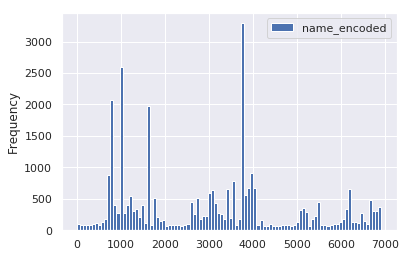

In [10]:
table[['nome','name_encoded']].plot.hist(bins=100)

In [11]:
print(f'Há um total de {len(np.unique(table.name_encoded.values))} occorências nesta amostra')

Há um total de 6920 occorências nesta amostra


### Duracação médias dos problemas (início até serem resolvidos)

A grande maioria é resolvido entre 0 e 25000 segundos. Há alguns pontos fora da normalidade que demoram mais para serem resolvidos como pode ser visto principalmente no boxplot.

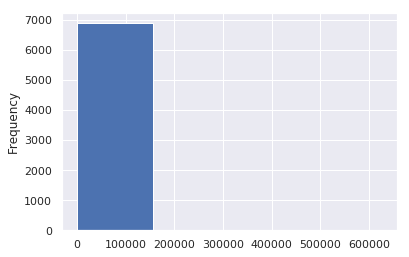

In [12]:
table.groupby('name_encoded').duracao_s.mean().plot.hist(bins=4)

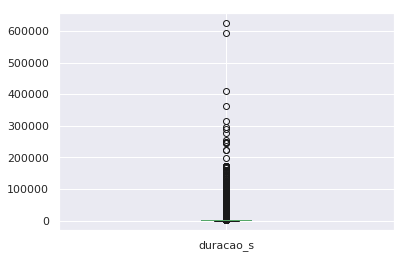

In [13]:
table.groupby('name_encoded').duracao_s.mean().plot.box()

## Análise da duração do problema que mais ocorre

In [14]:
key_value = dict(table.groupby('name_encoded').name_encoded.count())

In [15]:
greater_problem = max(key_value, key=key_value.get)

In [16]:
print(f'O problema que mais ocorre é o {table[table["name_encoded"]==greater_problem]["nome"].iloc[0]}')

O problema que mais ocorre é o CPU acima de 90


In [17]:
sub_table =table[table['name_encoded']==greater_problem]

In [18]:
sub_table[['duracao_s']].describe()

,duracao_s
count,1398.000000
mean,461.967096
std,1440.327801
min,59.000000
25%,60.000000
50%,180.000000
75%,360.000000
max,39360.000000


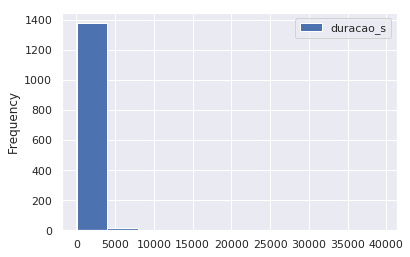

In [19]:
sub_table[['duracao_s']].plot.hist()

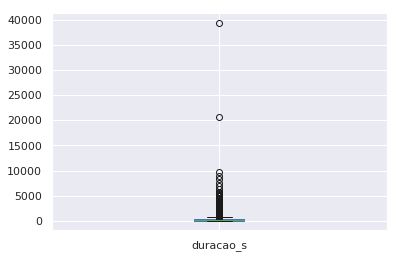

In [20]:
sub_table[['duracao_s']].plot.box()

## Analisando relação entre as ocorrências

In [23]:
# Carregar dados em um dicionario
dados = table.iloc[:].values

In [24]:
dict_ocorrencia = {} # o dicionario armazena, para cada ocorrência, a lista de ocorrências que ocorreram no intervalo de 1 hora
for i in range(len(dados)):
    horario_limite = (dados[i][2])+pd.Timedelta(hours=1)
    lista_ocorrencias = []
    for j in range(i+1, len(dados)):
        if (dados[j][2] <= horario_limite and dados[j][1] == dados[i][1]):
            lista_ocorrencias.append([j, dados[j][5]])
        else:
            break
    dict_ocorrencia[(i, dados[i][5])] = lista_ocorrencias  # tupla (id_ocorrencia, lista de ocorrências)

In [25]:
# intervalo de abertura e fechamento

dict_ocorrencia_intervalo = {} # o dicionario armazena, para cada ocorrência, a lista de ocorrências que ocorreram no intervalo de 1 hora
for i in range(len(dados)):
    #horario_limite = (dados[i][2])+pd.Timedelta(hours=1)
    lista_ocorrencias = []
    for j in range(i+1, len(dados)):
        if ( (dados[j][2] >= dados[i][2] and dados[j][2] <= dados[i][3]) and dados[j][1] == dados[i][1] ):
        #if (dados[j][2] <= horario_limite and dados[j][1] == dados[i][1]):
            lista_ocorrencias.append([j, dados[j][5]])
        else:
            break
    dict_ocorrencia_intervalo[(i, dados[i][5])] = lista_ocorrencias  # tupla (id_ocorrencia, lista de ocorrências)

In [26]:
from tqdm import tqdm
# 30 min antes e 1 hora depois

dict_ocorrencia_1 = {} # o dicionario armazena, para cada ocorrência, a lista de ocorrências que ocorreram no intervalo de 1 hora
for i in tqdm(range(len(dados))):
    horario_antes = (dados[i][2])-pd.Timedelta(minutes=30)
    horario_depois = (dados[i][2])+pd.Timedelta(hours=1)
    lista_ocorrencias = []
    for j in range(len(dados)):
        if ( (dados[j][2] >= horario_antes and dados[j][2] <= horario_depois) and dados[j][1] == dados[i][1] ):
        #if (dados[j][2] <= horario_limite and dados[j][1] == dados[i][1]):
            lista_ocorrencias.append([j, dados[j][5]])
        #else:
            #break
    dict_ocorrencia_1[(i, dados[i][5])] = lista_ocorrencias  # tupla (id_ocorrencia, lista de ocorrências)

 51%|█████     | 17044/33291 [10:05<08:09, 33.16it/s]

KeyboardInterrupt: 

In [44]:
def buscar_ocorrencias(name_encoded, dicionario): 
    chaves = dicionario.keys()
    chaves_ocorrencias = []
    for i in range(len(dicionario)):
        if ((i, name_encoded) in chaves):
            key = (i, name_encoded)
            chaves_ocorrencias.append(key)
    return chaves_ocorrencias # dado o código de um evento é retornado o(s) id(s) da(s) ocorrências que aquele evento ocorreu

import collections

def listar_ocorrencias(chaves, dicionario):
    ocorrencias = []
    for chave in chaves:
        for i in range(len(dicionario[chave])):
            ocorrencias.append(str(dicionario[chave][i][1]))
    return collections.Counter(ocorrencias) # os eventos são organizados em uma coleção

def gerar_grafico(coll_ocorrencias, n_ocorrencias):
    mais_comum = dict(coll_ocorrencias.most_common(n_ocorrencias))
    
    import matplotlib.pyplot as plt
    ocorr = list(mais_comum.keys())
    qtd_ocorr = list(mais_comum.values())

    plt.bar(ocorr, qtd_ocorr, color='red', width=0.2)
    plt.xticks(ocorr)
    plt.ylabel('qtd de ocorrências')
    plt.xlabel('cod. evento')
    plt.rcParams['figure.figsize'] = (30,10)
    plt.show()

In [38]:
def run_analise_relacao(dicionario, cod_ocorrencia, n_ocorrencias):
    keys = buscar_ocorrencias(cod_ocorrencia, dicionario)
    c = listar_ocorrencias(keys, dicionario)
    gerar_grafico(c, n_ocorrencias)

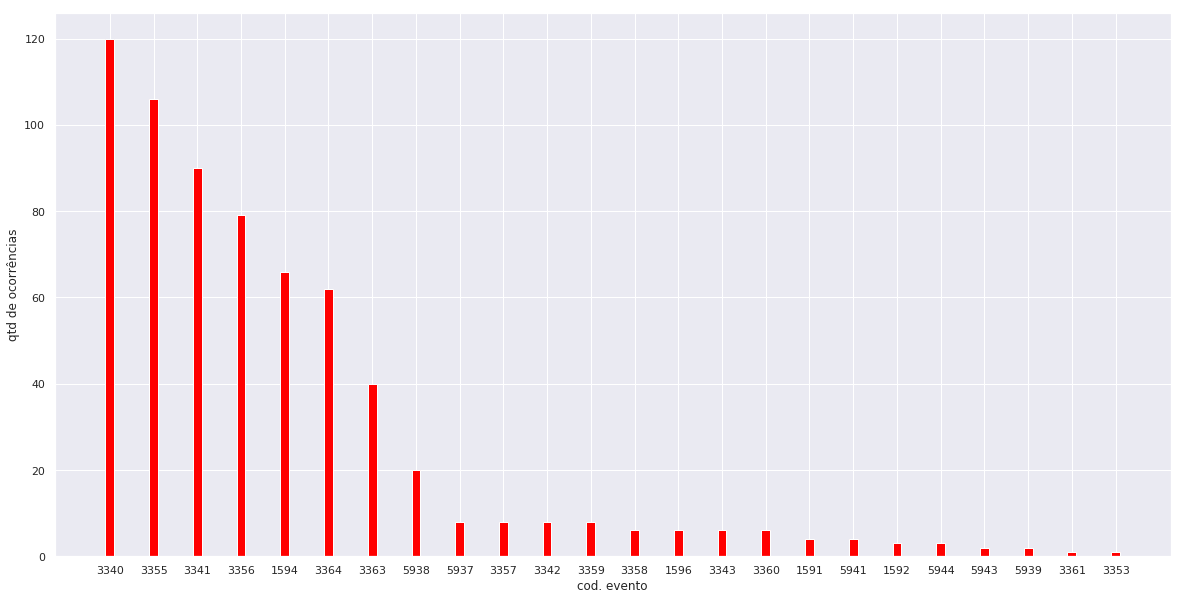

In [73]:
# dados - em formato de dicionario c/ todas as ocorrências
# cod_evento
# qtd de eventos relacionados


# o gráfico vai mostrar para dado um evento quais os n eventos que mais ocorreram

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)
run_analise_relacao(dict_ocorrencia_1, 3340, 25)

A abordagem de considerar um intervalo antes e depois de uma ocorrência parece ser interessante. Observe o gráfico acima. O evento 'Gateway REDEMETAGW Down' tem três principais eventos que co-ocorrem na maioria das vezes (.85 - .79%)

* Rota do Gateway Group: Redemeta_Priority foi alterada
* Rota do Gateway Group: EAD_Priority foi alterada
* Rota do Gateway Group: EAD_Priority usando gateway alternativo

In [72]:
# pra saber o nome do evento
print(lbe.classes_[1594])
print(lbe.classes_[3355])
print(lbe.classes_[3340])
print(lbe.classes_[3341])

Gateway REDEMETAGW Down
Rota do Gateway Group: Redemeta_Priority foi alterada
Rota do Gateway Group: EAD_Priority foi alterada
Rota do Gateway Group: EAD_Priority usando gateway alternativo


## Análise de relação por dia

In [95]:
table.query('name_encoded in [1594]')

,nome,host,abertura,fechamento,duracao_s,name_encoded
142,Gateway REDEMETAGW Down,Host_USC-pri-fw,2019-03-30 00:11:09,2019-03-30 00:15:09,240,1594
143,Gateway REDEMETAGW Down,USC-pri-fw01,2019-03-30 00:11:25,2019-03-30 00:14:25,180,1594
272,Gateway REDEMETAGW Down,Host_USC-pri-fw,2019-03-30 06:26:13,2019-03-30 06:29:09,176,1594
273,Gateway REDEMETAGW Down,USC-pri-fw01,2019-03-30 06:26:25,2019-03-30 06:29:25,180,1594
373,Gateway REDEMETAGW Down,Host_USC-pri-fw,2019-03-30 10:43:10,2019-03-30 10:47:10,240,1594
374,Gateway REDEMETAGW Down,USC-pri-fw01,2019-03-30 10:43:25,2019-03-30 10:47:25,240,1594
1063,Gateway REDEMETAGW Down,USC-pri-fw01,2019-03-31 19:14:26,2019-04-01 08:41:25,48419,1594
1066,Gateway REDEMETAGW Down,Host_USC-pri-fw,2019-03-31 19:15:10,2019-03-31 19:18:09,179,1594
1286,Gateway REDEMETAGW Down,Host_USC-pri-fw,2019-04-01 08:26:10,2019-04-01 08:41:10,900,1594
1533,Gateway REDEMETAGW Down,USC-pri-fw01,2019-04-01 15:03:25,2019-04-01 15:06:26,181,1594


## Analisando ocorrências por hosts

In [71]:
print(f'Quantidade de hosts: {np.unique(table.host.values).shape[0]}')

Quantidade de hosts:2411


In [128]:
df = table.copy()
lbe = LabelEncoder()
df['host_encoded'] = lbe.fit_transform(df.host.values)
df_group = df.groupby('host_encoded').name_encoded.agg(['size', 'count', 'nunique']).iloc[:50,:]

### Quantidade ocorrências por host
O primeiro plot leva em consideração a quantidade (independentemente se ocorre repetições de eventos)
O segundo plot leva em consideração a quantidade sem repetições.

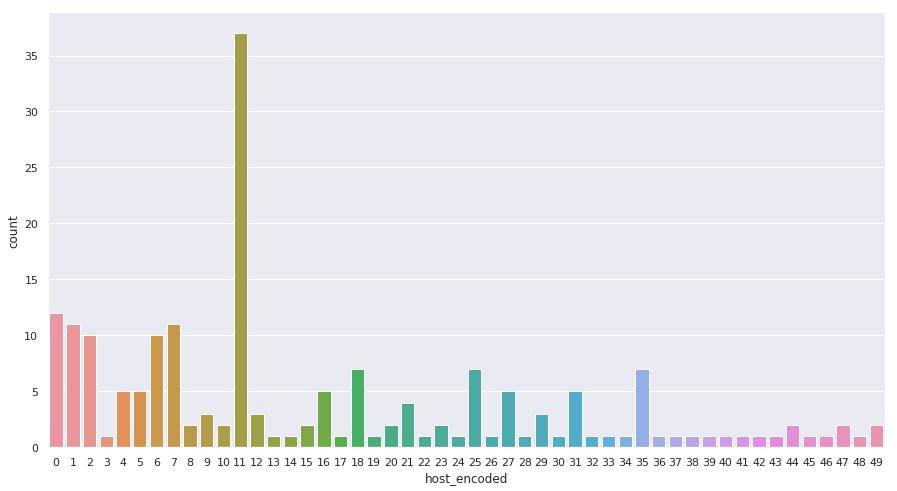

In [129]:
plt.figure(figsize=(15,8))
sns.barplot(x='host_encoded', y='count', data=df_group.reset_index())

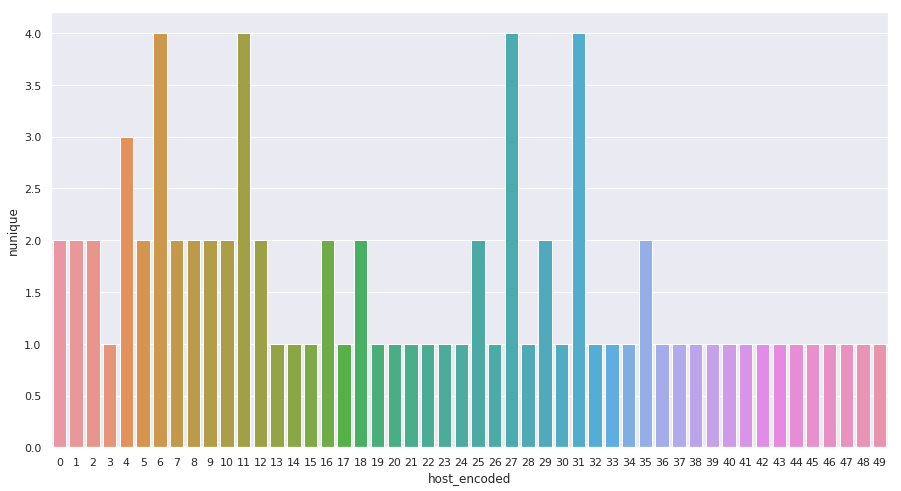

In [130]:
plt.figure(figsize=(15,8))
sns.barplot(x='host_encoded', y='nunique', data=df_group.reset_index())

In [142]:
f'Host com maior número de ocorrências: {lbe.inverse_transform(df_group[df_group["count"] == df_group[["count"]].max()[0]].index[0])}'

/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'Host com maior número de ocorrências: A-Brand - Rio Desing Leblon'

In [143]:
f'Host com maior número de ocorrências distintas: {lbe.inverse_transform(df_group[df_group["nunique"] == df_group[["nunique"]].max()[0]].index[0])}'


/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'Host com maior número de ocorrências distintas: A-Brand - Higienopolis'

In [148]:
df.groupby('host_encoded').name_encoded.agg(['size', 'count', 'nunique']).describe()

,size,count,nunique
count,2413.000000,2413.000000,2413.000000
mean,13.861583,13.861583,4.088272
std,89.954355,89.954355,15.447260
min,1.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000
50%,4.000000,4.000000,2.000000
75%,10.000000,10.000000,4.000000
max,4195.000000,4195.000000,548.000000


In [149]:
table.head()

,nome,host,abertura,fechamento,duracao_s,name_encoded
0,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,845
1,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,845
2,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,845
3,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,845
4,Utilização de Download no link INTEGRA_VIVO ac...,INT-poa-fw,2019-03-29 16:05:05,2019-03-29 16:06:04,59,6149


In [220]:
def get_events_between(table)->dict():
    dict_event_between = dict()
    for idx in tqdm(table.index):
        abertura = table.at[idx,'abertura']
        fechamento = table.at[idx,'fechamento']
        host = table.at[idx,'host']
        name_encoded = table[(table['abertura'] >= abertura) &
                             (table['fechamento']<=fechamento) &
                             (table['host']==host)].name_encoded.values.tolist()
        dict_event_between[idx]={table.at[idx,'name_encoded']:name_encoded, 'host':host}
    return dict_event_between
dict_event_between = get_events_between(table)



  0%|          | 0/33448 [00:00<?, ?it/s]

  0%|          | 15/33448 [00:00<03:49, 145.79it/s]

  0%|          | 30/33448 [00:00<03:50, 145.12it/s]

  0%|          | 45/33448 [00:00<03:50, 145.01it/s]

  0%|          | 57/33448 [00:00<04:08, 134.57it/s]

  0%|          | 71/33448 [00:00<04:09, 133.75it/s]

  0%|          | 87/33448 [00:00<03:58, 139.67it/s]

  0%|          | 104/33448 [00:00<03:48, 146.07it/s]

  0%|          | 121/33448 [00:00<03:40, 151.39it/s]

  0%|          | 138/33448 [00:00<03:34, 155.45it/s]

  0%|          | 155/33448 [00:01<03:30, 158.18it/s]

  1%|          | 173/33448 [00:01<03:25, 161.97it/s]

  1%|          | 192/33448 [00:01<03:17, 168.19it/s]

  1%|          | 211/33448 [00:01<03:11, 173.55it/s]

  1%|          | 230/33448 [00:01<03:08, 176.44it/s]

  1%|          | 249/33448 [00:01<03:06, 178.22it/s]

  1%|          | 268/33448 [00:01<03:04, 179.83it/s]

  1%|          | 287/33448 [00:01<03:03, 180.86it/s]

  1%|          | 306/33448 [00:01<03:02, 18

  7%|▋         | 2498/33448 [00:14<03:00, 171.66it/s]

  8%|▊         | 2516/33448 [00:14<03:03, 169.00it/s]

  8%|▊         | 2533/33448 [00:14<03:03, 168.28it/s]

  8%|▊         | 2550/33448 [00:14<03:06, 165.47it/s]

  8%|▊         | 2567/33448 [00:14<03:07, 164.47it/s]

  8%|▊         | 2584/33448 [00:14<03:09, 162.87it/s]

  8%|▊         | 2603/33448 [00:14<03:03, 168.42it/s]

  8%|▊         | 2620/33448 [00:14<03:04, 166.73it/s]

  8%|▊         | 2637/33448 [00:14<03:17, 155.88it/s]

  8%|▊         | 2654/33448 [00:15<03:13, 159.33it/s]

  8%|▊         | 2671/33448 [00:15<03:09, 161.99it/s]

  8%|▊         | 2688/33448 [00:15<03:07, 163.77it/s]

  8%|▊         | 2705/33448 [00:15<03:06, 165.01it/s]

  8%|▊         | 2722/33448 [00:15<03:05, 166.03it/s]

  8%|▊         | 2739/33448 [00:15<03:03, 166.93it/s]

  8%|▊         | 2756/33448 [00:15<03:03, 167.53it/s]

  8%|▊         | 2775/33448 [00:15<02:57, 173.29it/s]

  8%|▊         | 2794/33448 [00:15<02:53, 176.99it/s]

  8%|▊    

 15%|█▍        | 5003/33448 [00:27<02:34, 184.07it/s]

 15%|█▌        | 5022/33448 [00:28<02:34, 183.91it/s]

 15%|█▌        | 5041/33448 [00:28<02:33, 184.74it/s]

 15%|█▌        | 5060/33448 [00:28<02:33, 184.88it/s]

 15%|█▌        | 5079/33448 [00:28<02:33, 184.78it/s]

 15%|█▌        | 5098/33448 [00:28<02:33, 184.55it/s]

 15%|█▌        | 5117/33448 [00:28<02:34, 183.62it/s]

 15%|█▌        | 5136/33448 [00:28<02:34, 183.75it/s]

 15%|█▌        | 5155/33448 [00:28<02:33, 183.76it/s]

 15%|█▌        | 5174/33448 [00:28<02:33, 184.17it/s]

 16%|█▌        | 5193/33448 [00:28<02:33, 183.87it/s]

 16%|█▌        | 5212/33448 [00:29<02:33, 183.66it/s]

 16%|█▌        | 5231/33448 [00:29<02:33, 183.64it/s]

 16%|█▌        | 5250/33448 [00:29<02:33, 183.65it/s]

 16%|█▌        | 5269/33448 [00:29<02:33, 183.75it/s]

 16%|█▌        | 5288/33448 [00:29<02:33, 183.79it/s]

 16%|█▌        | 5307/33448 [00:29<02:33, 183.77it/s]

 16%|█▌        | 5326/33448 [00:29<02:32, 183.91it/s]

 16%|█▌   

 22%|██▏       | 7524/33448 [00:41<02:22, 182.29it/s]

 23%|██▎       | 7543/33448 [00:41<02:22, 182.42it/s]

 23%|██▎       | 7562/33448 [00:42<02:21, 182.99it/s]

 23%|██▎       | 7581/33448 [00:42<02:21, 183.33it/s]

 23%|██▎       | 7600/33448 [00:42<02:20, 183.56it/s]

 23%|██▎       | 7619/33448 [00:42<02:21, 182.95it/s]

 23%|██▎       | 7638/33448 [00:42<02:20, 183.81it/s]

 23%|██▎       | 7657/33448 [00:42<02:20, 183.89it/s]

 23%|██▎       | 7676/33448 [00:42<02:20, 183.00it/s]

 23%|██▎       | 7695/33448 [00:42<02:21, 181.96it/s]

 23%|██▎       | 7714/33448 [00:42<02:20, 182.61it/s]

 23%|██▎       | 7733/33448 [00:43<02:20, 183.05it/s]

 23%|██▎       | 7752/33448 [00:43<02:20, 183.28it/s]

 23%|██▎       | 7771/33448 [00:43<02:20, 182.29it/s]

 23%|██▎       | 7790/33448 [00:43<02:21, 181.06it/s]

 23%|██▎       | 7809/33448 [00:43<02:21, 181.76it/s]

 23%|██▎       | 7828/33448 [00:43<02:20, 181.98it/s]

 23%|██▎       | 7847/33448 [00:43<02:20, 181.85it/s]

 24%|██▎  

 30%|██▉       | 9992/33448 [00:55<02:06, 185.26it/s]

 30%|██▉       | 10011/33448 [00:55<02:06, 185.63it/s]

 30%|██▉       | 10030/33448 [00:56<02:06, 185.15it/s]

 30%|███       | 10049/33448 [00:56<02:05, 185.81it/s]

 30%|███       | 10068/33448 [00:56<02:06, 185.50it/s]

 30%|███       | 10087/33448 [00:56<02:06, 185.06it/s]

 30%|███       | 10106/33448 [00:56<02:05, 185.66it/s]

 30%|███       | 10125/33448 [00:56<02:05, 186.27it/s]

 30%|███       | 10144/33448 [00:56<02:05, 185.13it/s]

 30%|███       | 10163/33448 [00:56<02:06, 184.49it/s]

 30%|███       | 10182/33448 [00:56<02:15, 171.68it/s]

 30%|███       | 10200/33448 [00:57<02:17, 169.04it/s]

 31%|███       | 10218/33448 [00:57<02:26, 158.20it/s]

 31%|███       | 10235/33448 [00:57<02:24, 161.17it/s]

 31%|███       | 10252/33448 [00:57<02:32, 151.92it/s]

 31%|███       | 10269/33448 [00:57<02:28, 156.14it/s]

 31%|███       | 10286/33448 [00:57<02:25, 159.63it/s]

 31%|███       | 10303/33448 [00:57<02:22, 162.01

 37%|███▋      | 12471/33448 [01:09<01:53, 184.94it/s]

 37%|███▋      | 12490/33448 [01:09<01:53, 185.06it/s]

 37%|███▋      | 12509/33448 [01:09<01:53, 184.58it/s]

 37%|███▋      | 12528/33448 [01:09<01:53, 185.05it/s]

 38%|███▊      | 12547/33448 [01:10<01:52, 185.58it/s]

 38%|███▊      | 12566/33448 [01:10<01:52, 185.08it/s]

 38%|███▊      | 12585/33448 [01:10<01:52, 185.85it/s]

 38%|███▊      | 12604/33448 [01:10<01:51, 186.64it/s]

 38%|███▊      | 12623/33448 [01:10<01:52, 185.79it/s]

 38%|███▊      | 12642/33448 [01:10<01:52, 185.05it/s]

 38%|███▊      | 12661/33448 [01:10<01:52, 184.61it/s]

 38%|███▊      | 12680/33448 [01:10<01:52, 184.25it/s]

 38%|███▊      | 12699/33448 [01:10<01:52, 183.95it/s]

 38%|███▊      | 12718/33448 [01:10<01:52, 184.16it/s]

 38%|███▊      | 12737/33448 [01:11<01:51, 185.10it/s]

 38%|███▊      | 12757/33448 [01:11<01:50, 186.53it/s]

 38%|███▊      | 12777/33448 [01:11<01:50, 187.61it/s]

 38%|███▊      | 12796/33448 [01:11<01:50, 187.2

 45%|████▍     | 14981/33448 [01:23<01:40, 184.13it/s]

 45%|████▍     | 15000/33448 [01:23<01:39, 184.78it/s]

 45%|████▍     | 15019/33448 [01:23<01:40, 184.12it/s]

 45%|████▍     | 15038/33448 [01:23<01:40, 184.02it/s]

 45%|████▌     | 15057/33448 [01:23<01:39, 184.88it/s]

 45%|████▌     | 15076/33448 [01:23<01:39, 184.41it/s]

 45%|████▌     | 15096/33448 [01:23<01:38, 186.62it/s]

 45%|████▌     | 15115/33448 [01:23<01:38, 186.18it/s]

 45%|████▌     | 15134/33448 [01:24<01:38, 185.41it/s]

 45%|████▌     | 15153/33448 [01:24<01:38, 185.10it/s]

 45%|████▌     | 15172/33448 [01:24<01:39, 184.31it/s]

 45%|████▌     | 15191/33448 [01:24<01:39, 184.13it/s]

 45%|████▌     | 15210/33448 [01:24<01:39, 183.96it/s]

 46%|████▌     | 15229/33448 [01:24<01:38, 184.32it/s]

 46%|████▌     | 15248/33448 [01:24<01:38, 184.90it/s]

 46%|████▌     | 15267/33448 [01:24<01:37, 185.71it/s]

 46%|████▌     | 15286/33448 [01:24<01:37, 185.38it/s]

 46%|████▌     | 15305/33448 [01:24<01:37, 185.1

 52%|█████▏    | 17493/33448 [01:36<01:26, 185.22it/s]

 52%|█████▏    | 17512/33448 [01:36<01:26, 184.81it/s]

 52%|█████▏    | 17532/33448 [01:36<01:25, 186.98it/s]

 52%|█████▏    | 17551/33448 [01:37<01:24, 187.05it/s]

 53%|█████▎    | 17570/33448 [01:37<01:25, 186.10it/s]

 53%|█████▎    | 17589/33448 [01:37<01:32, 172.26it/s]

 53%|█████▎    | 17607/33448 [01:37<01:32, 170.52it/s]

 53%|█████▎    | 17625/33448 [01:37<01:33, 169.24it/s]

 53%|█████▎    | 17643/33448 [01:37<01:33, 168.51it/s]

 53%|█████▎    | 17660/33448 [01:37<01:34, 167.87it/s]

 53%|█████▎    | 17677/33448 [01:37<01:33, 167.87it/s]

 53%|█████▎    | 17696/33448 [01:37<01:31, 171.62it/s]

 53%|█████▎    | 17715/33448 [01:38<01:30, 174.46it/s]

 53%|█████▎    | 17734/33448 [01:38<01:28, 176.89it/s]

 53%|█████▎    | 17753/33448 [01:38<01:27, 178.36it/s]

 53%|█████▎    | 17772/33448 [01:38<01:27, 180.18it/s]

 53%|█████▎    | 17791/33448 [01:38<01:26, 180.49it/s]

 53%|█████▎    | 17810/33448 [01:38<01:26, 181.3

 60%|█████▉    | 19929/33448 [01:50<01:21, 165.27it/s]

 60%|█████▉    | 19946/33448 [01:50<01:23, 161.81it/s]

 60%|█████▉    | 19963/33448 [01:50<01:24, 159.54it/s]

 60%|█████▉    | 19980/33448 [01:51<01:25, 157.77it/s]

 60%|█████▉    | 19997/33448 [01:51<01:24, 159.14it/s]

 60%|█████▉    | 20015/33448 [01:51<01:22, 163.33it/s]

 60%|█████▉    | 20033/33448 [01:51<01:20, 165.90it/s]

 60%|█████▉    | 20051/33448 [01:51<01:19, 168.99it/s]

 60%|██████    | 20069/33448 [01:51<01:17, 171.76it/s]

 60%|██████    | 20088/33448 [01:51<01:16, 174.87it/s]

 60%|██████    | 20107/33448 [01:51<01:15, 176.59it/s]

 60%|██████    | 20126/33448 [01:51<01:14, 177.73it/s]

 60%|██████    | 20144/33448 [01:51<01:14, 177.85it/s]

 60%|██████    | 20163/33448 [01:52<01:13, 179.59it/s]

 60%|██████    | 20181/33448 [01:52<01:13, 179.38it/s]

 60%|██████    | 20199/33448 [01:52<01:16, 173.96it/s]

 60%|██████    | 20217/33448 [01:52<01:22, 161.31it/s]

 60%|██████    | 20234/33448 [01:52<01:24, 156.9

 67%|██████▋   | 22335/33448 [02:04<01:05, 170.25it/s]

 67%|██████▋   | 22353/33448 [02:04<01:05, 168.70it/s]

 67%|██████▋   | 22370/33448 [02:04<01:06, 166.56it/s]

 67%|██████▋   | 22387/33448 [02:04<01:06, 166.84it/s]

 67%|██████▋   | 22404/33448 [02:05<01:06, 167.30it/s]

 67%|██████▋   | 22421/33448 [02:05<01:06, 166.79it/s]

 67%|██████▋   | 22438/33448 [02:05<01:06, 165.36it/s]

 67%|██████▋   | 22455/33448 [02:05<01:07, 163.67it/s]

 67%|██████▋   | 22472/33448 [02:05<01:07, 161.76it/s]

 67%|██████▋   | 22489/33448 [02:05<01:09, 157.10it/s]

 67%|██████▋   | 22505/33448 [02:05<01:15, 145.61it/s]

 67%|██████▋   | 22520/33448 [02:05<01:18, 138.40it/s]

 67%|██████▋   | 22536/33448 [02:05<01:16, 143.45it/s]

 67%|██████▋   | 22551/33448 [02:06<01:16, 142.97it/s]

 67%|██████▋   | 22568/33448 [02:06<01:13, 147.90it/s]

 68%|██████▊   | 22583/33448 [02:06<01:14, 146.36it/s]

 68%|██████▊   | 22598/33448 [02:06<01:19, 137.09it/s]

 68%|██████▊   | 22615/33448 [02:06<01:15, 143.5

 74%|███████▍  | 24737/33448 [02:18<00:53, 163.20it/s]

 74%|███████▍  | 24754/33448 [02:18<00:54, 159.60it/s]

 74%|███████▍  | 24771/33448 [02:18<00:57, 152.16it/s]

 74%|███████▍  | 24787/33448 [02:18<00:57, 151.85it/s]

 74%|███████▍  | 24803/33448 [02:18<00:57, 151.44it/s]

 74%|███████▍  | 24820/33448 [02:19<00:55, 154.98it/s]

 74%|███████▍  | 24838/33448 [02:19<00:53, 159.70it/s]

 74%|███████▍  | 24855/33448 [02:19<00:58, 147.30it/s]

 74%|███████▍  | 24872/33448 [02:19<00:56, 151.76it/s]

 74%|███████▍  | 24888/33448 [02:19<00:55, 154.05it/s]

 74%|███████▍  | 24905/33448 [02:19<00:54, 156.16it/s]

 75%|███████▍  | 24922/33448 [02:19<00:54, 156.80it/s]

 75%|███████▍  | 24938/33448 [02:19<00:54, 156.41it/s]

 75%|███████▍  | 24955/33448 [02:19<00:53, 158.30it/s]

 75%|███████▍  | 24972/33448 [02:19<00:52, 160.49it/s]

 75%|███████▍  | 24989/33448 [02:20<00:52, 161.86it/s]

 75%|███████▍  | 25006/33448 [02:20<00:52, 160.64it/s]

 75%|███████▍  | 25023/33448 [02:20<00:55, 150.7

 81%|████████  | 27088/33448 [02:32<00:34, 184.86it/s]

 81%|████████  | 27107/33448 [02:32<00:34, 184.95it/s]

 81%|████████  | 27126/33448 [02:32<00:34, 184.09it/s]

 81%|████████  | 27145/33448 [02:32<00:34, 184.10it/s]

 81%|████████  | 27164/33448 [02:32<00:34, 183.78it/s]

 81%|████████▏ | 27183/33448 [02:33<00:34, 183.57it/s]

 81%|████████▏ | 27202/33448 [02:33<00:33, 184.45it/s]

 81%|████████▏ | 27221/33448 [02:33<00:33, 185.22it/s]

 81%|████████▏ | 27240/33448 [02:33<00:33, 185.73it/s]

 81%|████████▏ | 27259/33448 [02:33<00:33, 185.69it/s]

 82%|████████▏ | 27278/33448 [02:33<00:33, 184.81it/s]

 82%|████████▏ | 27297/33448 [02:33<00:33, 184.58it/s]

 82%|████████▏ | 27316/33448 [02:33<00:33, 185.20it/s]

 82%|████████▏ | 27335/33448 [02:33<00:33, 184.71it/s]

 82%|████████▏ | 27354/33448 [02:33<00:32, 184.80it/s]

 82%|████████▏ | 27373/33448 [02:34<00:32, 185.55it/s]

 82%|████████▏ | 27392/33448 [02:34<00:32, 186.11it/s]

 82%|████████▏ | 27411/33448 [02:34<00:32, 185.6

 88%|████████▊ | 29489/33448 [02:46<00:23, 166.21it/s]

 88%|████████▊ | 29506/33448 [02:46<00:24, 162.42it/s]

 88%|████████▊ | 29523/33448 [02:46<00:26, 150.12it/s]

 88%|████████▊ | 29539/33448 [02:46<00:26, 149.34it/s]

 88%|████████▊ | 29555/33448 [02:46<00:26, 148.91it/s]

 88%|████████▊ | 29571/33448 [02:47<00:25, 149.20it/s]

 88%|████████▊ | 29586/33448 [02:47<00:25, 149.05it/s]

 89%|████████▊ | 29604/33448 [02:47<00:24, 156.04it/s]

 89%|████████▊ | 29620/33448 [02:47<00:25, 148.28it/s]

 89%|████████▊ | 29636/33448 [02:47<00:25, 151.57it/s]

 89%|████████▊ | 29652/33448 [02:47<00:26, 145.27it/s]

 89%|████████▊ | 29668/33448 [02:47<00:25, 149.12it/s]

 89%|████████▊ | 29684/33448 [02:47<00:25, 147.88it/s]

 89%|████████▉ | 29700/33448 [02:47<00:25, 149.13it/s]

 89%|████████▉ | 29716/33448 [02:47<00:24, 152.09it/s]

 89%|████████▉ | 29733/33448 [02:48<00:24, 154.54it/s]

 89%|████████▉ | 29750/33448 [02:48<00:23, 157.46it/s]

 89%|████████▉ | 29767/33448 [02:48<00:23, 158.5

 95%|█████████▌| 31827/33448 [03:00<00:08, 184.83it/s]

 95%|█████████▌| 31846/33448 [03:00<00:08, 184.49it/s]

 95%|█████████▌| 31865/33448 [03:00<00:08, 184.55it/s]

 95%|█████████▌| 31884/33448 [03:00<00:08, 184.52it/s]

 95%|█████████▌| 31903/33448 [03:01<00:08, 184.71it/s]

 95%|█████████▌| 31922/33448 [03:01<00:08, 185.05it/s]

 95%|█████████▌| 31941/33448 [03:01<00:08, 185.50it/s]

 96%|█████████▌| 31960/33448 [03:01<00:08, 185.73it/s]

 96%|█████████▌| 31979/33448 [03:01<00:07, 186.44it/s]

 96%|█████████▌| 31998/33448 [03:01<00:07, 186.13it/s]

 96%|█████████▌| 32017/33448 [03:01<00:07, 185.86it/s]

 96%|█████████▌| 32036/33448 [03:01<00:07, 185.29it/s]

 96%|█████████▌| 32055/33448 [03:01<00:07, 185.16it/s]

 96%|█████████▌| 32074/33448 [03:01<00:07, 184.27it/s]

 96%|█████████▌| 32093/33448 [03:02<00:07, 183.77it/s]

 96%|█████████▌| 32112/33448 [03:02<00:07, 183.88it/s]

 96%|█████████▌| 32131/33448 [03:02<00:07, 184.37it/s]

 96%|█████████▌| 32151/33448 [03:02<00:06, 186.9

### Pretendo fazer uma análise de eventos por host
Objetivo criar sequência temporal de eventos por host e verificar se há padrões. Cada sequência pode estar num
intervalo de um dia ou 1 mês etc. Verificar se há correlação entre sequências de hosts, pois dessa forma podemos pensar num possível modelo para sequência.